# MHC class II genotype vs CH risk

- note: this is the script to reproduce the figures from the report
- more complete analysis is provided in additional scripts 

## Import packages

In [2]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from myfunctions import transform_format


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:

timestr = time.strftime("%Y%m%d") # get current date 

In [4]:
# specify font for plotting 
plt.rcParams.update({'font.sans-serif':'Verdana'})

## Import batch data

In [5]:

folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  # Path to ukb files from Hamish 

# Get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# Initialize an empty dictionary 
dataframes = {}

# Iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# Extract dataframes 
for file_name, df in dataframes.items():
    
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign dataframe to the variable 


# Concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# Row bind all batch dataframes into a single one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

print('Number of samples with variants examined:', batch_all.shape[0])


Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [6]:

# Change numerical variables to integers

batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['sample_ID'] = batch_all['sample_ID'].astype(int)

# Subset and create new useful columns

batch_all = batch_all[['sample_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[1] # alternative (CH) variant
batch_all['ref_variant'] = batch_all['Amino_acids'].str.split('/', expand = True)[0] # reference variant 

# There are some cases where there is no change in amino acids, for now save as NaN 

batch_all['alt_variant'].fillna(batch_all['Amino_acids'], inplace=True)
batch_all['ref_variant'].fillna(batch_all['Amino_acids'], inplace=True)

# Exclude data with singletons (likely errors)

batch_all_ns = batch_all[batch_all['var_depth'] >= 2]

# Number of samples with two variant reads or more 
print('Number of samples carrying more than a single read with the variant sequence:', batch_all_ns.shape[0])
# okay so we have 2823 of these but then note that only 2249 are with CH variants 
# so like 20% of >= 2 reads are not v likely to be real? should conslut with Jamie 

batch_all_ns.head(n = 10)

Number of samples carrying more than a single read with the variant sequence: 2823


,sample_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt_variant,ref_variant
41,2100538,chr17,7674894,0.036364,2,55,R/*,TP53,Cga/Tga,batch_21_annotated_data,*,R
56,2100679,chr2,25234373,0.048780,4,82,R/H,DNMT3A,cGc/cAc,batch_21_annotated_data,H,R
59,2100706,chr2,25234307,0.019417,2,103,P/L,DNMT3A,cCg/cTg,batch_21_annotated_data,L,P
64,2100777,chr2,25240313,0.020833,2,96,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
65,2100788,chr2,25240420,0.131148,8,61,Y/C,DNMT3A,tAc/tGc,batch_21_annotated_data,C,Y
83,2101006,chr2,25240420,0.027778,2,72,Y/S,DNMT3A,tAc/tCc,batch_21_annotated_data,S,Y
109,2101361,chr17,76736877,0.025641,2,78,P/H,SRSF2,cCc/cAc,batch_21_annotated_data,H,P
126,2101637,chr2,25240313,0.021739,2,92,R/*,DNMT3A,Cga/Tga,batch_21_annotated_data,*,R
130,2101708,chr17,7675088,0.033898,2,59,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R
154,2102011,chr15,90088702,0.097561,4,41,R/Q,IDH2,cGg/cAg,batch_21_annotated_data,Q,R


In [7]:

# Import indexes tested in each batch 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  # Path to ukb files from Hamish 

# Get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# Read each file one by one 

indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'sample_ID'})
    id['sample_ID'] = id['sample_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():
    
    variable_name = file_name.split('/')[9].split('.')[0]    # Remove file extension
    globals()[variable_name] = df  # Assign the DataFrame to a variable with the file name


## Annotate samples with genetic variants carried

In [8]:

# Find out how many gene_variants were called:

# don't show warnings 
import warnings
warnings.filterwarnings("ignore")

# identify variants called 
batch_all_ns['variant_coord'] = batch_all_ns['chromosome'].astype(str) + "_" + batch_all_ns['end_position'].astype(str) # specific position in the genome 
batch_all_ns['variant_coord'] = batch_all_ns['variant_coord'].astype('category')
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord'].astype(str) +  "_" + batch_all_ns['SYMBOL'].astype(str) + "_" + batch_all_ns['ref_variant'].astype(str) + "_" + batch_all_ns['alt_variant'].astype(str) # change to a specific aa
batch_all_ns['variant_coord_pos'] = batch_all_ns['variant_coord_pos'].astype('category')

# remove samples that have not been annotated (you can tell from the coordinate what is likely but these could be different mutations)
batch_all_ns = batch_all_ns.dropna(subset=['SYMBOL']) # remove column where gene is not known 
print('Number of samples which have been correctly annotated:', batch_all_ns.shape[0]) # but at each site, you are getting reads modified to sth else 
# ok so sth worked wrong with annotation in only 5 cases > that looks good 

# identify the number of variants in a specific position
num_variants = pd.DataFrame(batch_all_ns['variant_coord_pos'].value_counts())
num_variants = num_variants[num_variants['count']!=0]
num_variants = num_variants.sort_values(by = 'count')
num_variants['variant_coord_pos'] = num_variants.index
num_variants = num_variants.reset_index(drop=True)
num_variants = num_variants.sort_values(by = 'variant_coord_pos')
print('Number of variants identified in batches analysed:', num_variants.shape[0]) # but at each site, you are getting reads modiifed to sth else 

# identify the number of positions we looked at
num_sites = pd.DataFrame(batch_all_ns['variant_coord'].value_counts())
num_sites = num_sites[num_sites['count']!=0]
num_sites = num_sites.sort_values(by = 'count')
num_sites['variant_coord'] = num_sites.index
num_sites = num_sites.reset_index(drop=True)
num_sites = num_sites.sort_values(by = 'variant_coord')
print('Number of sites identified in batches analysed:', num_sites.shape[0]) # okay see so you only found 37 sites 

# we have more variants than sites because for each site, we look at any change from the reference sequence (any possible variant)
# at the same time, because we have this data, we can check if we have more variants that "random" mutations

# save coordinates to a df
pd.DataFrame(num_variants.variant_coord_pos.unique().tolist()).to_csv('/Users/barbarawalkowiak/Desktop/variants_annotated.csv')

Number of samples which have been correctly annotated: 2818
Number of variants identified in batches analysed: 89
Number of sites identified in batches analysed: 41


In [9]:

# Annotation (using df with variant names and genomic coordinates)

# read in the df with coordinates
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# all coordinates identified in the batches  
coord_out = num_sites['variant_coord'].tolist()

# intersection (annotate)
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt_variant'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref_variant'].astype(str) + "_" + coord_gene_var['alt_variant'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

# NB we removed one variant bc the coordinates were incorrect

# NOTE: 
# TP53_R249S was searched for but not found in any of the batches so far 
# there have been 5 samples identified (in DNMT3A, at 2 different sites) with variants that I did not originally search for 
# in addition, some of the variants were offset by one base (could have been a deletion / insertion)
# this is why we have differences in the number of sites in the two datasets 


Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [10]:

# identify CH variants typed in the dataset 
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all_ns, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()
batch_gene_vars.rename(columns = {'sample_ID' : 'Person_ID'}, inplace = True)

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples with a mutation in a CH-relevant position (with >2 reads):', batch_all_ns.shape[0])
print('Number of patients with a mutation in a CH-relevant position (with >2 reads):', len(batch_all_ns.sample_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.Person_ID.unique()))


Number of variants identified with annotations: 32
Number of samples with a mutation in a CH-relevant position (with >2 reads): 2818
Number of patients with a mutation in a CH-relevant position (with >2 reads): 2761
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214


## Add age data

In [11]:

# load the age dataset 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']]
age_df.columns.values[0] = 'Person_ID'
age_df.columns.values[1] = 'age'
print('Number of individuals for whom age data is available:', age_df.shape[0])

Number of individuals for whom age data is available: 459385


In [12]:

# add age data to the rest of the data 
batch_gene_vars.gene_var = batch_gene_vars.gene_var.astype(str)
batch_gene_vars.gene_var = batch_gene_vars.gene_var.astype('category') # remove previous categories we will not be looking at
batch_gene_age = pd.merge(batch_gene_vars, age_df, on = 'Person_ID') # add age to everyone who has a variant
print("Number of sample with available CH variant:", batch_gene_vars.shape[0]) # note we are using the filtered dataframe here 
print("Number of sample with available CH variant and age:", batch_gene_age.shape[0]) # these are healthy / non-cancer cases (can think if we want to filter out the cancer ones, but tbf probably yes)
# note: this is throwing away patients who have been diagnosed with cancer (this dataset is for healthy individuals only)

Number of sample with available CH variant: 2249
Number of sample with available CH variant and age: 1986


# Load MHC class II genotype data

In [13]:

# add MHC II genotype data to CH cases

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df.columns = head 

# subset data for HLA-I and HLA-II class alleles 
# we are only interested in HLA-I for the momnet 
df_hla1 = df.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df.filter(regex='^(Person_|D)') # 488377 cases 

df_clean_hla2 = df_hla2[~df_hla2.isin([0.5]).any(axis=1)] # exclude people for whom we lack full genotype data
df_clean_hla2 = df_clean_hla2[~df_clean_hla2.isin([1.5]).any(axis=1)] # exclude people for whom we lack full genotype data

# we will analyse DR and DP / DQ alleles separately because the "rules" are different (ie alpha / beta chain combinations etc.)
# NOTE: I am removing samples for which we don't have correct allele annotation
df_hla2_dp = df_clean_hla2.filter(regex='^(Person_|DP)')
df_hla2_dq = df_clean_hla2.filter(regex='^(Person_|DQ)')
df_hla2_dr = df_clean_hla2.filter(regex='^(Person_|DR)')

print("Number of samples with MHC II genotype imputation data", df_hla2.shape[0])
print("Number of samples with MHC II genotype confidently imputed", df_clean_hla2.shape[0]) # not ideal as this really throws out a lot of the data we have actually 

Number of samples with MHC II genotype imputation data 488377
Number of samples with MHC II genotype confidently imputed 378317


In [14]:

# okay, a problem with DP / DQ is that we have predictions for COMBINATIONS
# therefore, we need to create columns with combinations and use them for when we make the prediction

# what we can do is create additional columns and set the value to 1 if someone has both alleles (who knows if they will have the combination
# but if predictions are available for it in NetMHCII we can assume that maybe it's legit)

from itertools import combinations

# combinations for DQ
cc = list(combinations(df_hla2_dq.columns[1:],2)) # possible combinations of these columns (first is Person_ID)
df_hla2_dq_comb = pd.concat([df_hla2_dq[c[0]].multiply(df_hla2_dq[c[1]]) for c in cc], axis=1, keys=cc) 
# we are multiplying
# in this way, if someone has >= 1 in both alleles they will get a positive number
# even if they have 2 alleles in one allele but 0 in the other, they will get a zero

df_hla2_dq_comb.columns = df_hla2_dq_comb.columns.map('-'.join) # join with a '-'

# repeat the same for DP 
cc = list(combinations(df_hla2_dp.columns[1:],2)) # possible combinations of these columns (first is Person_ID)
df_hla2_dp_comb = pd.concat([df_hla2_dp[c[0]].multiply(df_hla2_dp[c[1]]) for c in cc], axis=1, keys=cc) 
# we are multiplying
# in this way, if someone has >= 1 in both alleles they will get a positive number
# even if they have 2 alleles in one allele but 0 in the other, they will get a zero

df_hla2_dp_comb.columns = df_hla2_dp_comb.columns.map('-'.join) # join with a '-'


In [15]:
# okay, now: we do not want to predict stuff for 2 alpha or 2 beta chains because these are not created so we can remove these columns
# we also want to rename columns from XXB-XXA to XXA-XXB
def is_valid_column_name(col):
    parts = col.split('-') # two part of the name of the column
    return 'A' in parts[0] and 'B' in parts[1] or 'B' in parts[0] and 'A' in parts[1]

def switch_parts(col):
    parts = col.split('-') 
    new_name = parts[1] + '-' + parts[0]
    return new_name

In [16]:

# remove columns with BB or AA combinations 
filtered_columns_dp = [col for col in df_hla2_dp_comb.columns if is_valid_column_name(col)]
filtered_columns_dq = [col for col in df_hla2_dq_comb.columns if is_valid_column_name(col)]

# Create a new DataFrame with the filtered and reordered columns
new_df_dp = df_hla2_dp_comb[filtered_columns_dp]
new_df_dq = df_hla2_dq_comb[filtered_columns_dq]

renamed_columns_dp = [switch_parts(col) for col in new_df_dp.columns]
renamed_columns_dq = [switch_parts(col) for col in new_df_dq.columns]

new_df_dp.columns = renamed_columns_dp
new_df_dq.columns = renamed_columns_dq

In [17]:

# once we have selected the correct columns, combine with other data

# DP
df_hla2_dp_all = pd.concat([df_hla2_dp, new_df_dp], axis = 1)
df_hla2_dp_all.replace(2, 1, inplace=True) # if someone got a 2 (2 * 1), replace to 1
df_hla2_dp_all.replace(4, 1, inplace=True) # if someone got a 2 (2 * 2), replace to 1

# let's remove columns where noone has the combination (it's possible that some combinations are never seen in our dataset)
colsums = pd.DataFrame(df_hla2_dp_all.sum()).reset_index()
colsums.rename(columns={'index': 'col_name', 0:'col_sum'}, inplace=True)
col_to_retain = colsums[colsums['col_sum']>=1]['col_name'] # these are the columns to retain 
df_hla2_dp_all = df_hla2_dp_all[col_to_retain]
df_hla2_dp_all 

# DQ
df_hla2_dq_all = pd.concat([df_hla2_dq, new_df_dq], axis = 1)
df_hla2_dq_all.replace(2, 1, inplace=True) # if someone got a 2 (2 * 1), replace to 1
df_hla2_dq_all.replace(4, 1, inplace=True) # if someone got a 2 (2 * 1), replace to 1

# let's remove columns where noone has the combination (it's possible that some combinations are never seen in our dataset)
colsums = pd.DataFrame(df_hla2_dq_all.sum()).reset_index()
colsums.rename(columns={'index': 'col_name', 0:'col_sum'}, inplace=True)
col_to_retain = colsums[colsums['col_sum']>=1]['col_name'] # these are the columns to retain 
df_hla2_dq_all = df_hla2_dq_all[col_to_retain]
df_hla2_dq_all 

,Person_ID,DQB1_201,DQB1_202,DQB1_301,DQB1_302,DQB1_303,DQB1_304,DQB1_401,DQB1_402,DQB1_501,...,DQA1_102-DQB1_609,DQA1_103-DQB1_609,DQA1_201-DQB1_609,DQA1_301-DQB1_609,DQA1_302-DQB1_609,DQA1_303-DQB1_609,DQA1_401-DQB1_609,DQA1_501-DQB1_609,DQA1_505-DQB1_609,DQA1_601-DQB1_609
1,4860169,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3381323,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2805252,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3318036,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4120291,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488370,4478244,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488373,3573995,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488374,1206874,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488375,3025735,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Load MHC binding affinity prediction

In [18]:

# parameters
param = '%Rank_EL' # let's do it on EL ranks first 

# NOTE: In the original file (sub), I was missing a score for DNMT3A_R736C_ch so I generated it separately with the same code and will concatenate the files here 
# load the file with binding predictions across variants
pred_file_dpq_sub = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240211_NetMHC_HLA_UKBB_with_affinities_DP_DQ_bestscores.csv"
pred_file_dpq_r736c = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240215_NetMHC_HLA_UKBB_with_affinities_DP_DQ_R736C_bestscores.csv"
pred_file_dpq_stop = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DP_DQ_stopcodons_bestscores.csv"
pred_method = pred_file_dpq_sub.split('_out')[0] # all are with the same method so does not matter which file you end up using 
 
# organize file with prediction scores for DP and DQ alleles 
pred_filename_dpq_sub = pred_file_dpq_sub.split('/')[2].split('.')[0]
pred_filename_dpq_stop = pred_file_dpq_stop.split('/')[2].split('.')[0]
pred_df_dpq_sub = pd.read_csv(pred_file_dpq_sub)
pred_df_dpq_r736c = pd.read_csv(pred_file_dpq_r736c)
pred_df_dpq_stop = pd.read_csv(pred_file_dpq_stop)

# In the sub file, I had some predictions for STOP-codon-containing variants, I don't want these so remove them
pred_df_dpq_sub = pred_df_dpq_sub[~pred_df_dpq_sub['gene_var'].str.contains('\*')]

# concat the files 
pred_df_dpq_stop.drop(columns=['Affinity (nM)'], inplace=True)
pred_df_dpq_r736c.drop(columns=['Affinity (nM)'], inplace=True)
pred_df_dpq = pd.concat([pred_df_dpq_sub, pred_df_dpq_stop, pred_df_dpq_r736c], ignore_index = True)
pred_df_dpq['gene_var_gt'] = pred_df_dpq['gene'] + '_' + pred_df_dpq['variant'] + '_' + pred_df_dpq['genotype'] # create a column that includes all genotype data

# organize file with prediction scores for DR alleles 
pred_file_dr_sub = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DR_bestscores.csv"
pred_file_dr_r736c = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240215_NetMHC_HLA_UKBB_with_affinities_DR_R736C_bestscores.csv"
pred_file_dr_stop = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DR_stopcodons_bestscores.csv"

# organize file with prediction scores for DR alleles 
pred_filename_dr_sub = pred_file_dr_sub.split('/')[2].split('.')[0]
pred_filename_dr_stop = pred_file_dr_stop.split('/')[2].split('.')[0]
pred_df_dr_sub = pd.read_csv(pred_file_dr_sub)
pred_df_dr_r736c = pd.read_csv(pred_file_dr_r736c)
pred_df_dr_stop = pd.read_csv(pred_file_dr_stop)

# In the sub file, I had some predictions for STOP-codon-containing variants, I don't want these so remove them
pred_df_dr_sub = pred_df_dr_sub[~pred_df_dr_sub['gene_var'].str.contains('\*')]

# remove affinity columns
pred_df_dr_stop.drop(columns=['Affinity (nM)'], inplace=True)
pred_df_dr_r736c.drop(columns=['Affinity(nM)'], inplace=True)

# concat the files 
pred_df_dr = pd.concat([pred_df_dr_sub, pred_df_dr_stop, pred_df_dr_r736c], ignore_index = True)
pred_df_dr['gene_var_gt'] = pred_df_dr['gene'] + '_' + pred_df_dr['variant'] + '_' + pred_df_dr['genotype'] # create a column that includes all genotype data
pred_df_dr.head(n = 5)


,Unnamed: 0,Pos,HLA,Peptide,Of,Core,Core_Rel,Inverted,Identity,Score_EL,%Rank_EL,Exp_Bind,BindLevel,gene,variant,genotype,gene_var,Score_BA,%Rank_BA,gene_var_gt
0,81173,1,DRB1_0101,IRHLFALLKEYFACV,4,FALLKEYFA,0.99,0,seq_9,0.035335,14.93,NaN,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,DNMT3A_P904L_ch
1,81178,1,DRB1_0102,SVPVIRHLFALLKEY,4,IRHLFALLK,0.96,0,seq_5,0.075223,15.46,NaN,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,DNMT3A_P904L_ch
2,81191,1,DRB1_0103,IRHLFALLKEYFACV,4,FALLKEYFA,0.99,0,seq_9,0.015829,21.55,NaN,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,DNMT3A_P904L_ch
3,81196,1,DRB1_0301,SVPVIRHLFALLKEY,4,IRHLFALLK,0.92,0,seq_5,0.003383,38.95,NaN,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,DNMT3A_P904L_ch
4,81206,1,DRB1_0302,VPVIRHLFALLKEYF,3,IRHLFALLK,0.89,0,seq_6,0.003467,51.72,NaN,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,DNMT3A_P904L_ch


In [19]:

# we need to move the format of the DP/DQ predictions to something that matches our UKBB genotyping and everything else 
def transform_format_DPQ(input_string):
    # Define a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w{3})(\d{1})(\d{4})-(\w{3})(\d{1})(\d{4})') # okay so this is the pattern we are trying to match

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # we are not including HLA annotations, this is the name of the first allele   
        group2 = int(match.group(2)) # there will be no zeroes, leave as it is 
        group3 = int(match.group(3)) # remove zeros at the start 
        group4 = match.group(4) # name of the second allele in the combination
        group5 = int(match.group(5)) # there will be no zeroes, leave as it is 
        group6 = int(match.group(6)) # remove zeros at the start 

        # Format the output string
        output_string = f'{group1}{group2}_{group3}-{group4}{group5}_{group6}' # stitch back 

        return output_string # return transformed string 

    # if no much, return original string 
    return 0

def transform_format_DR(input_string):
    # Define a regular expression pattern to match the input format
    pattern = re.compile(r'(\w{3})(\d{1})_(\d+)') # okay so this is the pattern we are trying to match

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # we are not including HLA annotations, this is the name of the first allele   
        group2 = int(match.group(2)) # there will be no zeroes, leave as it is 
        group3 = int(match.group(3)) # remove zeros at the start 

        # Format the output string
        output_string = f'{group1}{group2}_{group3}' # stitch back 

        return output_string # return transformed string 

    # if no much, return original string 
    return 0


In [20]:
# change format of HLA allele naming 
pred_df_dpq['HLA_formatted'] = pred_df_dpq['HLA'].map(transform_format_DPQ)
pred_df_dr['HLA_formatted'] = pred_df_dr['HLA'].map(transform_format_DR)

# combine all predictions
pred_df_all = pd.concat([pred_df_dpq, pred_df_dr], axis = 0)
pred_df_all.head()

,Unnamed: 0,Pos,HLA,Peptide,Of,Core,Core_Rel,Inverted,Identity,Score_EL,...,Score_BA,%Rank_BA,Affinity (nM),BindLevel,gene,variant,genotype,gene_var,gene_var_gt,HLA_formatted
0,181708,1,HLA-DPA10103-DPB10101,PVIRHLFALLKEYFA,3,RHLFALLKE,0.87,0,seq_7,0.112253,...,NaN,NaN,NaN,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_101
1,727345,1,HLA-DPA10103-DPB10201,SVPVIRHLFALLKEY,3,VIRHLFALL,1.00,0,seq_5,0.219174,...,<=,WB,NaN,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_201
2,249261,1,HLA-DPA10103-DPB10202,WSVPVIRHLFALLKE,4,VIRHLFALL,0.98,0,seq_4,0.248802,...,0.565826,4.66,109.69,<=,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_202
3,655999,1,HLA-DPA10103-DPB10301,GRSWSVPVIRHLFAL,1,RSWSVPVIR,0.64,0,seq_1,0.012210,...,0.558070,2.21,119.29,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_301
4,248910,1,HLA-DPA10103-DPB10401,WSVPVIRHLFALLKE,4,VIRHLFALL,0.98,0,seq_4,0.053899,...,0.490329,6.20,248.27,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_401


In [21]:

# now you need to merge the data that you want to use with the allele data to get predictions
# most comprehensive dataset we have is batch_gene_age (includes genetic variant someone carries and age)
# Find IDs of CH-affected persons and match to their HLA genotype 

batch_gene_vars.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
batch_gene_age.rename(columns={'sample_ID': 'Person_ID'}, inplace=True)
ids_batch = batch_gene_age['Person_ID']
hla_batch_ids_dr = df_hla2_dr[df_hla2_dr['Person_ID'].isin(ids_batch)] 

# add HLA genotype data to samples with annotated CH variant and age
batch_gene_hla_dr = pd.merge(batch_gene_vars, df_hla2_dr, on='Person_ID')
batch_gene_hla_dp = pd.merge(batch_gene_vars, df_hla2_dp_all, on='Person_ID')
batch_gene_hla_dq = pd.merge(batch_gene_vars, df_hla2_dq_all, on='Person_ID')

batch_gene_age_hla_dr = pd.merge(batch_gene_age, df_hla2_dr, on='Person_ID')
batch_gene_age_hla_dp = pd.merge(batch_gene_age, df_hla2_dp_all, on='Person_ID')
batch_gene_age_hla_dq = pd.merge(batch_gene_age, df_hla2_dq_all, on='Person_ID')

print("Number of samples with available CH variant:", batch_gene_vars.shape[0])
print('Number of samples with annotated variants CH variant and HLA genotype (DR):', batch_gene_hla_dr.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and HLA genotype (DP):', batch_gene_hla_dp.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and HLA genotype (DQ):', batch_gene_hla_dq.shape[0]) # 1 HLA genotype missing 
print("Number of samples with available CH variant and age:", batch_gene_age.shape[0])
print('Number of samples with annotated variants CH variant and age and HLA genotype (DR):', batch_gene_age_hla_dr.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and age and HLA genotype (DP):', batch_gene_age_hla_dp.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and age and HLA genotype (DQ):', batch_gene_age_hla_dq.shape[0]) # 1 HLA genotype missing 


Number of samples with available CH variant: 2249
Number of samples with annotated variants CH variant and HLA genotype (DR): 1746
Number of samples with annotated variants CH variant and HLA genotype (DP): 1746
Number of samples with annotated variants CH variant and HLA genotype (DQ): 1746
Number of samples with available CH variant and age: 1986
Number of samples with annotated variants CH variant and age and HLA genotype (DR): 1539
Number of samples with annotated variants CH variant and age and HLA genotype (DP): 1539
Number of samples with annotated variants CH variant and age and HLA genotype (DQ): 1539


In [22]:
# create a dataframe with all relevant genotype (DRB1 + DQ combinations + DP combinations)
batch_gene_hla_dp_comb = pd.concat([batch_gene_hla_dp.iloc[:, 0], batch_gene_hla_dp.iloc[:, 14], batch_gene_hla_dp.iloc[:, 56:]], axis = 1)
batch_gene_hla_dq_comb = pd.concat([batch_gene_hla_dq.iloc[:, 0], batch_gene_hla_dq.iloc[:, 14], batch_gene_hla_dq.iloc[:, 47:]], axis = 1)
batch_gene_hla_all = pd.merge(batch_gene_hla_dr, batch_gene_hla_dp_comb, on = ['Person_ID', 'gene_var'])                             
batch_gene_hla_all = pd.merge(batch_gene_hla_all, batch_gene_hla_dq_comb, on = ['Person_ID', 'gene_var']) 

In [23]:
# add age data
batch_gene_age_hla_all = pd.merge(batch_gene_hla_all, age_df, on = 'Person_ID')
batch_gene_age_hla_all

,Person_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,...,DQA1_103-DQB1_609,DQA1_201-DQB1_609,DQA1_301-DQB1_609,DQA1_302-DQB1_609,DQA1_303-DQB1_609,DQA1_401-DQB1_609,DQA1_501-DQB1_609,DQA1_505-DQB1_609,DQA1_601-DQB1_609,age
0,2100538,chr17,7674894,0.036364,2,55,R/*,TP53,Cga/Tga,batch_21_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0
1,1641209,chr17,7674894,0.260000,13,50,R/*,TP53,Cga/Tga,batch_16_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0
2,1471938,chr17,7674894,0.032787,2,61,R/*,TP53,Cga/Tga,batch_14_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0
3,1482881,chr17,7674894,0.028571,2,70,R/*,TP53,Cga/Tga,batch_14_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0
4,1946555,chr17,7674894,0.051282,2,39,R/*,TP53,Cga/Tga,batch_19_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,1619263,chr15,90088606,0.031250,2,64,R/K,IDH2,aGg/aAg,batch_16_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0
1535,1456018,chr15,90088606,0.032258,2,62,R/K,IDH2,aGg/aAg,batch_14_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0
1536,2045629,chr15,90088606,0.031746,2,63,R/K,IDH2,aGg/aAg,batch_20_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,61.0
1537,1740102,chr1,114716126,0.060606,2,33,G/D,NRAS,gGt/gAt,batch_17_annotated_data,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,67.0


In [24]:

# Filtering 2: we will only be looking at variants for which we have more than 10 samples 
gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

variants_to_examine = gene_vars_sorted[gene_vars_sorted['count'] >= 15].gene_var.tolist()
print('Number of variants to examine (common variants):', len(variants_to_examine))

# filter the dataframe to only include CH variants with minimum 10 samples 
# we will be using this dataset going forward 
batch_gene_age_hla_dr_10 = batch_gene_age_hla_dr[batch_gene_age_hla_dr['gene_var'].isin(variants_to_examine)]
batch_gene_age_hla_dp_10 = batch_gene_age_hla_dp[batch_gene_age_hla_dp['gene_var'].isin(variants_to_examine)]
batch_gene_age_hla_dq_10 = batch_gene_age_hla_dq[batch_gene_age_hla_dq['gene_var'].isin(variants_to_examine)]
batch_gene_age_hla_all_10 = batch_gene_age_hla_all[batch_gene_age_hla_all['gene_var'].isin(variants_to_examine)]
print('Number of samples with a CH hotspot mutation (with > 2 reads):', batch_gene_vars.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads):', len(batch_gene_vars.Person_ID.unique()))
print('Number of samples with a CH hotspot mutation (with > 2 reads) (common variants):', batch_gene_age_hla_all_10.shape[0])
print('Number of patients with a CH hotspot mutation (with > 2 reads) (common variants):', len(batch_gene_age_hla_all_10.Person_ID.unique()))


Number of variants to examine (common variants): 20
Number of samples with a CH hotspot mutation (with > 2 reads): 2249
Number of patients with a CH hotspot mutation (with > 2 reads): 2214
Number of samples with a CH hotspot mutation (with > 2 reads) (common variants): 1478
Number of patients with a CH hotspot mutation (with > 2 reads) (common variants): 1455


In [25]:
# reset number of categories of variants
batch_gene_age_hla_dr_10['gene_var'] = batch_gene_age_hla_dr_10['gene_var'].astype(str)
batch_gene_age_hla_dr_10['gene_var'] = batch_gene_age_hla_dr_10['gene_var'].astype('category')
batch_gene_age_hla_dp_10['gene_var'] = batch_gene_age_hla_dp_10['gene_var'].astype(str)
batch_gene_age_hla_dp_10['gene_var'] = batch_gene_age_hla_dp_10['gene_var'].astype('category')
batch_gene_age_hla_dq_10['gene_var'] = batch_gene_age_hla_dq_10['gene_var'].astype(str)
batch_gene_age_hla_dq_10['gene_var'] = batch_gene_age_hla_dq_10['gene_var'].astype('category')

batch_gene_age_hla_all_10['gene_var'] = batch_gene_age_hla_all_10['gene_var'].astype(str)
batch_gene_age_hla_all_10['gene_var'] = batch_gene_age_hla_all_10['gene_var'].astype('category')


# Add scores based on MHC class II genotype

In [26]:

# oki basically we need to figure out what is wrong with this function

# define function to find the best score for the variant that is carried (ie present in the person)
def find_best_score_for_variant_carried(row, df, param):

    '''
    This functiion is applied to the CH dataset
    The df is the dataset with predictions for given allele and genetic variant 
    parameter is what to base this prediction on (here will only be using %Rank_EL)
    '''
    
    # these are the values of rows to seach for 
    row_values = pd.to_numeric(row[1:-1], errors='coerce')
    
    # find alleles which are present 
    hla = row.index[1:-1][row_values >= 1]  
    
    # find values corresponding to these alleles 
    vals = df.loc[df['gene_var'] == row['gene_var'], hla].values.flatten() 
    
    # it can be that nothing was found e.g., bc there were no predictions made for this variant
    if vals.size == 0: 
        value = None
    
    else: 
    
        # note here we will only be using '%Rank_EL'
        if param == "Aff_nM":
            value = min(vals) # highest affinity corresponds to lowest value (see plots above)
        elif param == "%Rank_EL":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_EL":
            value = max(vals) # the best score is the highest one 
        elif param == "%Rank_BA":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_BA":
            value = max(vals) # the best score is the highest one
        else:
            print('Incorrect parameter provided') 
    
    return value  

In [27]:

# do this for DR alleles 
param = '%Rank_EL'

# DR
pred_sub_dr = pred_df_dr[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_dr_wide = pd.pivot(pred_sub_dr, index='gene_var_gt', columns='HLA_formatted', values=param)
pred_sub_dr_wide = pred_sub_dr_wide.reset_index() # this is to make sure that you have the gene_var column in there too

hla_ukbb_dr = batch_gene_age_hla_dr_10.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dr = pred_sub_dr_wide.columns[pred_sub_dr_wide.columns.isin(hla_ukbb_dr)] # HLA in the UKBB which I have predictions for 
hla_intersect_dr_list = hla_intersect_dr.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dr = pred_sub_dr_wide[hla_intersect_dr_list + pred_sub_dr_wide.columns[pred_sub_dr_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dr = pred_sub_dr[pred_sub_dr['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dr = batch_gene_age_hla_dr_10[hla_intersect_dr_list + batch_gene_age_hla_dr_10.columns[batch_gene_age_hla_dr_10.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dr = pd.concat([batch_gene_age_hla_dr_10["Person_ID"], ch_hla_sub_dr], axis=1) # add CH cases 
ch_hla_sub_dr['score'] = ch_hla_sub_dr.apply(find_best_score_for_variant_carried, df=pred_sub_dr, param=param, axis=1) # add score for the parameter
ch_hla_scores_dr = ch_hla_sub_dr.dropna() # remove NA (incorrectly annotated cases)

# merge scores with VAF and age
age_vaf_dr = batch_gene_age_hla_dr_10[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_merge_dr = pd.merge(ch_hla_scores_dr, age_vaf_dr, on = ['Person_ID', 'gene_var'])

# now add the columns with VAF and age 
col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
ch_hla_merge_sub_dr = ch_hla_merge_dr[col_to_select]
ch_hla_merge_sub_dr['log_score'] = -1*np.log10(ch_hla_merge_sub_dr['score']) # convert score to -log10(score)
ch_hla_merge_sub_dr['allele_type'] = 'DR'


In [28]:

# DP
pred_sub_dpq = pred_df_dpq[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_dpq = pred_sub_dpq[~pred_sub_dpq.duplicated()] # remove duplicate columns 
pred_sub_dpq_reset = pred_sub_dpq.reset_index()
pred_sub_dpq_wide = pd.pivot(pred_sub_dpq_reset, index='gene_var_gt', columns='HLA_formatted', values=param)
pred_sub_dpq_wide = pred_sub_dpq_wide.reset_index() # this is to make sure that you have the gene_var column in there too

hla_ukbb_dp = batch_gene_age_hla_dp_10.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dp = pred_sub_dpq_wide.columns[pred_sub_dpq_wide.columns.isin(hla_ukbb_dp)] # HLA in the UKBB which I have predictions for 
hla_intersect_dp_list = hla_intersect_dp.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dp = pred_sub_dpq_wide[hla_intersect_dp_list + pred_sub_dpq_wide.columns[pred_sub_dpq_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dp = pred_sub_dp[pred_sub_dp['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dp['gene_var'] = pred_sub_dp['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dp = batch_gene_age_hla_dp_10[hla_intersect_dp_list + batch_gene_age_hla_dp_10.columns[batch_gene_age_hla_dp_10.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dp = pd.concat([batch_gene_age_hla_dp_10["Person_ID"], ch_hla_sub_dp], axis=1) # add CH cases 
ch_hla_sub_dp['score'] = ch_hla_sub_dp.apply(find_best_score_for_variant_carried, df=pred_sub_dp, param=param, axis=1) # add score for the parameter
ch_hla_scores_dp = ch_hla_sub_dp.dropna() # remove NA (incorrectly annotated cases)

# merge scores with VAF and age
age_vaf_dp = batch_gene_age_hla_dp[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_merge_dp = pd.merge(ch_hla_scores_dp, age_vaf_dp, on = ['Person_ID', 'gene_var'])

# now add the columns with VAF and age 
col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
ch_hla_merge_sub_dp = ch_hla_merge_dp[col_to_select]
ch_hla_merge_sub_dp['log_score'] = -1*np.log10(ch_hla_merge_sub_dp['score']) # convert score to -log10(score)
ch_hla_merge_sub_dp['allele_type'] = 'DP'


In [29]:

# DQ
hla_ukbb_dq = batch_gene_age_hla_dq_10.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dq = pred_sub_dpq_wide.columns[pred_sub_dpq_wide.columns.isin(hla_ukbb_dq)] # HLA in the UKBB which I have predictions for 
hla_intersect_dq_list = hla_intersect_dq.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dq = pred_sub_dpq_wide[hla_intersect_dq_list + pred_sub_dpq_wide.columns[pred_sub_dpq_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dq = pred_sub_dq[pred_sub_dq['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dq['gene_var'] = pred_sub_dq['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dq = batch_gene_age_hla_dq_10[hla_intersect_dq_list + batch_gene_age_hla_dq_10.columns[batch_gene_age_hla_dq_10.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dq = pd.concat([batch_gene_age_hla_dq_10["Person_ID"], ch_hla_sub_dq], axis=1) # add CH cases 
ch_hla_sub_dq['score'] = ch_hla_sub_dq.apply(find_best_score_for_variant_carried, df=pred_sub_dq, param=param, axis=1) # add score for the parameter
ch_hla_scores_dq = ch_hla_sub_dq.dropna() # remove NA (incorrectly annotated cases)

# merge scores with VAF and age
age_vaf_dq = batch_gene_age_hla_dq[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_merge_dq = pd.merge(ch_hla_scores_dq, age_vaf_dq, on = ['Person_ID', 'gene_var'])

# now add the columns with VAF and age 
col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
ch_hla_merge_sub_dq = ch_hla_merge_dq[col_to_select]
ch_hla_merge_sub_dq['log_score'] = -1*np.log10(ch_hla_merge_sub_dq['score']) # convert score to -log10(score)
ch_hla_merge_sub_dq['allele_type'] = 'DQ'


In [30]:
# we can actually combine all these scores now 
ch_hla_merge_sub_all = pd.concat([ch_hla_merge_sub_dr, ch_hla_merge_sub_dp, ch_hla_merge_sub_dq], axis = 0)
ch_hla_merge_sub_all

,Person_ID,gene_var,score,age,var_depth,VAF,log_score,allele_type
0,2100679,DNMT3A_R882H,7.50,69.0,4,0.048780,-0.875061,DR
1,2110983,DNMT3A_R882H,3.01,63.0,5,0.089286,-0.478566,DR
2,2116112,DNMT3A_R882H,11.18,60.0,5,0.066667,-1.048442,DR
3,2118726,DNMT3A_R882H,3.01,57.0,2,0.025316,-0.478566,DR
4,2120797,DNMT3A_R882H,11.18,45.0,6,0.127660,-1.048442,DR
...,...,...,...,...,...,...,...,...
1473,1415885,SF3B1_K666N,3.39,63.0,19,0.422222,-0.530200,DQ
1474,1435102,SF3B1_K666N,1.43,69.0,2,0.048780,-0.155336,DQ
1475,1444475,SF3B1_K666N,26.02,70.0,5,0.294118,-1.415307,DQ
1476,1445954,SF3B1_K666N,1.43,62.0,2,0.055556,-0.155336,DQ


In [31]:

# define function to find the best score for the variant that is carried (ie present in the person)
def find_best_score_for_variant_carried_all_hla(row, df, param):

    '''
    This functiion is applied to the CH dataset
    The df is the dataset with predictions for given allele and genetic variant 
    parameter is what to base this prediction on (here will only be using %Rank_EL)
    '''
    
    # these are the values of rows to seach for 
    row_values = pd.to_numeric(row[1:-1], errors='coerce')
    
    # find alleles which are present (NOTE this is changed from the previous function bc formatting is different)
    hla = row.index[1:-1][row_values >= 1]  
    
    # find values corresponding to these alleles 
    vals = df.loc[df['gene_var'] == row['gene_var'], hla].values.flatten() 
    
    # it can be that nothing was found e.g., bc there were no predictions made for this variant
    if vals.size == 0: 
        value = None
    
    else: 
    
        # note here we will only be using '%Rank_EL'
        if param == "Aff_nM":
            value = min(vals) # highest affinity corresponds to lowest value (see plots above)
        elif param == "%Rank_EL":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_EL":
            value = max(vals) # the best score is the highest one 
        elif param == "%Rank_BA":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_BA":
            value = max(vals) # the best score is the highest one
        else:
            print('Incorrect parameter provided') 
    
    return value  

In [32]:

# add a single score based on all of the MHC class II alleles someone has (not breaking down into DR, DP, DQ)

pred_sub_all = pred_df_all[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_all = pred_sub_all[~pred_sub_all.duplicated()] # remove duplicate columns 
pred_sub_all_reset = pred_sub_all.reset_index()
pred_sub_all_wide = pd.pivot(pred_sub_all_reset, index='gene_var_gt', columns='HLA_formatted', values=param).reset_index()

hla_ukbb_all = batch_gene_age_hla_all_10.columns[15:].tolist() # this includes DP / DQ and in combinations only
hla_intersect_all = pred_sub_all_wide.columns[pred_sub_all_wide.columns.isin(hla_ukbb_all)] # HLA in the UKBB which I have predictions for 
hla_intersect_all_list = hla_intersect_all.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_all = pred_sub_all_wide[hla_intersect_all_list + pred_sub_all_wide.columns[pred_sub_all_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_all = pred_sub_all[pred_sub_all['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_all['gene_var'] = pred_sub_all['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_all['gene_var'] = pred_sub_all['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_all['gene_var'] = pred_sub_all['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_all = batch_gene_age_hla_all_10[hla_intersect_all_list + batch_gene_age_hla_all_10.columns[batch_gene_age_hla_all.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_all = pd.concat([batch_gene_age_hla_all_10["Person_ID"], ch_hla_sub_all], axis=1) # add CH cases 
ch_hla_sub_all['score'] = ch_hla_sub_all.apply(find_best_score_for_variant_carried_all_hla, df=pred_sub_all, param=param, axis=1) # add score for the parameter
ch_hla_scores_all = ch_hla_sub_all.dropna() # remove NA (incorrectly annotated cases)

# merge scores with VAF and age
age_vaf_all = batch_gene_age_hla_all[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_merge_all = pd.merge(ch_hla_scores_all, age_vaf_all, on = ['Person_ID', 'gene_var'])

# now add the columns with VAF and age 
col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
ch_hla_merge_sub_all = ch_hla_merge_all[col_to_select]
ch_hla_merge_sub_all['log_score'] = -1*np.log10(ch_hla_merge_sub_all['score']) # convert score to -log10(score)

# filter out rare variants
ch_hla_merge_sub_all = ch_hla_merge_sub_all[ch_hla_merge_sub_all['gene_var'].isin(variants_to_examine)]
print('Number of alleles and allele combinations for which we have predictions:', len(hla_intersect_all_list))


Number of alleles and allele combinations for which we have predictions: 441


In [33]:

# SANITY CHECK: 
ch_hla_merge_sub_by_allele = pd.concat([ch_hla_merge_sub_dq, ch_hla_merge_sub_dp, ch_hla_merge_sub_dr], axis = 0)
ch_by_allele = pd.DataFrame(ch_hla_merge_sub_by_allele.groupby(['Person_ID', 'gene_var']).log_score.max()) # find best score across alleles
ch_sub = ch_hla_merge_sub_all[['Person_ID', 'gene_var', 'log_score']].sort_values(by = 'Person_ID') # compare to score added 
ch_diff = pd.merge(ch_by_allele, ch_sub, on = ['Person_ID', 'gene_var'])
ch_diff['diff'] = ch_diff['log_score_x'] - ch_diff['log_score_y']
ch_diff['diff'].sum()

0.0

In [34]:
# add columns to change gene var formatting and add number of individuals observed for each variant
ch_hla_merge_sub_all['gene_var2'] = ch_hla_merge_sub_all['gene_var'].str.replace('_', '\n')

# add counts
df_carriers_counts = ch_hla_merge_sub_all['gene_var'].value_counts().reset_index()
df_carriers_counts.columns.values[1] = 'nr_carriers'
df_carriers_counts.nr_carriers = df_carriers_counts.nr_carriers.astype(str)

ch_hla_merge_sub_all = pd.merge(ch_hla_merge_sub_all, df_carriers_counts, on = 'gene_var')
ch_hla_merge_sub_all['gene_var3'] = ch_hla_merge_sub_all['gene_var2'] + '\n(n=' + ch_hla_merge_sub_all['nr_carriers'] + ')'

In [35]:

# Okay, first, we need to get a score column so that will be a log score which matches the gene var someone has 
def get_score(row):
    
    category = row['gene_var']
    return row[f'score_{category}']

# split into a desired number of groups
def split_into_equal_groups(df, num_groups):

    # first, assign a rank to everyone based on score
    # the highest score = the lowest rank (ie highest score means you get rank 1)
    # if two people have the same score, assign consecutive ranks 
    df['rank'] = df['log_score'].rank(method='first', ascending=False)
    
    # assign groups based on rank 

    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    df_sort = df.sort_values(by = 'rank')
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    df_sort['group'] = group_assignments
    
    return df_sort

In [36]:

# define function to plot
def plot_ranks(data, x, y, hue, colors, order, plt_type, nr, hue_order = None, name = None):

    score = '-log10(%Rank_EL)'

    plt.figure(figsize = (16, 4))

    if hue_order is None:
        if plt_type == 'box':
            p = sns.boxplot(x=x, y=y, hue=hue, data=data, showfliers=False, palette=colors, order=order)
            plt.xticks(rotation=90, fontsize = 12)
            plt.yticks(fontsize = 13)
            plt.xlabel('CH hotspot variant carried', fontsize = 14)
            plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
            plt.title('MHC II', fontsize = 16)
            plt.ylim(-2.5, 2.5)
            plt.legend(title = 'Variant presentation', loc = 'upper right', fontsize = 13, title_fontsize = 14)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 8/UKBB_dist_{hue}_{y}_{plt_type}_{nr}_{name}.pdf', bbox_inches='tight')

        if plt_type == 'jitter':
            p = sns.stripplot(x=x, y=y, hue=hue, data=data, palette=colors, order=order, size = 5, alpha = 0.4)
            plt.xticks(rotation=90, fontsize = 12)
            plt.yticks(fontsize = 13)
            plt.xlabel('CH hotspot variant carried', fontsize = 14)
            plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
            plt.title('MHC II', fontsize = 16)
            plt.legend(title = 'Variant presentation', markerscale = 2, loc = 'upper right', fontsize = 13, title_fontsize = 14)
            plt.ylim(-2.5, 2.5)
            legend = plt.gca().get_legend()
            for handle, color in zip(legend.legendHandles, colors):
                handle.set_color(color)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 8/UKBB_dist_{hue}_{y}_{plt_type}_{nr}_{name}.pdf', bbox_inches='tight')

    else:
        if plt_type == 'box':
            p = sns.boxplot(x=x, y=y, hue=hue, data=data, showfliers=False, palette=colors, order=order, hue_order=hue_order)
            plt.xticks(rotation=90, fontsize = 12)
            plt.yticks(fontsize = 13)
            plt.xlabel('CH hotspot variant', fontsize = 14)
            plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
            plt.title('MHC II', fontsize = 16)
            plt.ylim(-2.5, 2.5)
            plt.legend(title = 'Variant presentation', loc = 'upper right', fontsize = 13, title_fontsize = 14)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 8/UKBB_dist_{hue}_{y}_{plt_type}_{nr}_{name}.pdf', bbox_inches='tight')

        if plt_type == 'jitter':
            p = sns.stripplot(x=x, y=y, hue=hue, data=data, palette=colors, order=order, hue_order=hue_order, size = 5, alpha = 0.4)
            plt.xticks(rotation=90, fontsize = 12)
            plt.yticks(fontsize = 13)
            plt.xlabel('CH hotspot variant', fontsize = 14)
            plt.ylabel(r'$\log_{10}$(min %EL rank)', fontsize = 14)
            plt.title('MHC II', fontsize = 16)
            plt.ylim(-2.5, 2.5)
            plt.legend(title = 'Variant presentation', loc = 'upper right', markerscale = 2, fontsize = 13, title_fontsize = 14)
            legend = plt.gca().get_legend()
            for handle, color in zip(legend.legendHandles, colors):
                handle.set_color(color)
            for lh in legend.legendHandles:
                lh.set_alpha(1)
            plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 8/UKBB_dist_{hue}_{y}_{plt_type}_{nr}_{name}.pdf', bbox_inches='tight')


In [37]:

# specify colors to use for plotting
col0 = '#910e0e'
col1 = '#ed5d5d'
col1b = '#fab9b2'
col2 = '#65e6f5'
col3 = '#1091af'

In [38]:

# specify order
ch_hla_merge_sub_all['median_score'] = ch_hla_merge_sub_all.groupby('gene_var')['log_score'].transform('median')
ch_hla_merge_sub_all = ch_hla_merge_sub_all.sort_values(by='median_score', ascending = False)
order = ch_hla_merge_sub_all.gene_var2.unique()

# split df into equal groups

# apply function separately to each category 
df_groups2_eqsize = ch_hla_merge_sub_all.groupby('gene_var2').apply(lambda x: split_into_equal_groups(x, num_groups=2))
df_groups3_eqsize = ch_hla_merge_sub_all.groupby('gene_var2').apply(lambda x: split_into_equal_groups(x, num_groups=3))
df_groups4_eqsize = ch_hla_merge_sub_all.groupby('gene_var2').apply(lambda x: split_into_equal_groups(x, num_groups=4))
df_groups5_eqsize = ch_hla_merge_sub_all.groupby('gene_var2').apply(lambda x: split_into_equal_groups(x, num_groups=5))

# add a more descriptive name for the group
df_groups2_eqsize['group_name'] =  df_groups2_eqsize['group'].map({1: 'top', 2: 'bottom'})
df_groups3_eqsize['group_name'] =  df_groups3_eqsize['group'].map({1: 'top', 2: 'mid', 3: 'bottom'})
df_groups4_eqsize['group_name'] =  df_groups4_eqsize['group'].map({1: 'top', 2: 'mid-high', 3: 'mid-low', 4: 'bottom'})
df_groups5_eqsize['group_name'] =  df_groups5_eqsize['group'].map({1: 'top', 2: 'mid-high', 3: 'mid', 4: 'mid-low', 5: 'bottom'})

# specify order of levels in group descriptors
cat_type2 = pd.CategoricalDtype(categories=['top', 'bottom'], ordered=True)
df_groups2_eqsize['group_name'] = df_groups2_eqsize['group_name'].astype(cat_type2)
df_groups2_eqsize['group_name'] = df_groups2_eqsize['group_name'].astype('category')

cat_type3 = pd.CategoricalDtype(categories=['top', 'mid', 'bottom'], ordered=True)
df_groups3_eqsize['group_name'] = df_groups3_eqsize['group_name'].astype(cat_type3)
df_groups3_eqsize['group_name'] = df_groups3_eqsize['group_name'].astype('category')

cat_type4 = pd.CategoricalDtype(categories=['top', 'mid-high', 'mid-low', 'bottom'], ordered=True)
df_groups4_eqsize['group_name'] = df_groups4_eqsize['group_name'].astype(cat_type4)
df_groups4_eqsize['group_name'] = df_groups4_eqsize['group_name'].astype('category')

cat_type5 = pd.CategoricalDtype(categories=['top', 'mid-high', 'mid', 'mid-low', 'bottom'], ordered=True)
df_groups5_eqsize['group_name'] = df_groups5_eqsize['group_name'].astype(cat_type5)
df_groups5_eqsize['group_name'] = df_groups5_eqsize['group_name'].astype('category')


In [39]:

# create plots
colors2 = [col0, col3]
hue_order2 = ['top', 'bottom']
scores_groups2_eqsize = df_groups2_eqsize.sort_values(by = 'log_score', ascending = False)

colors3 = [col0, col1b, col3]
hue_order3 = ['top','mid', 'bottom']
scores_groups3_eqsize = df_groups3_eqsize.sort_values(by = 'log_score', ascending = False)

colors4 = [col0, col1, col2, col3]
hue_order4 = ['top','mid-high', 'mid-low', 'bottom']
scores_groups4_eqsize = df_groups4_eqsize.sort_values(by = 'log_score', ascending = False)

colors5 = [col0, col1, col1b, col2, col3]
hue_order5 = ['top', 'mid-high', 'mid', 'mid-low', 'bottom']
scores_groups5_eqsize = df_groups5_eqsize.sort_values(by = 'log_score', ascending = False)


In [40]:
# specify order for plotting 
ch_hla_merge_sub_all['median_score'] = ch_hla_merge_sub_all.groupby('gene_var')['log_score'].transform('median')
ch_hla_merge_sub_all = ch_hla_merge_sub_all.sort_values(by='median_score', ascending = False)
order_3 = ch_hla_merge_sub_all.gene_var3.unique()

In [41]:

# add column with VAF data 
df_groups2_eqsize['VAF_percent'] = df_groups2_eqsize['VAF'] * 100
df_groups3_eqsize['VAF_percent'] = df_groups3_eqsize['VAF'] * 100
df_groups4_eqsize['VAF_percent'] = df_groups4_eqsize['VAF'] * 100
df_groups5_eqsize['VAF_percent'] = df_groups5_eqsize['VAF'] * 100

In [42]:

# define function to plot cumulative probability
def plot_cumulative(data, x, y, hue, colors, xlabel, ylabel, var, score, score_title, name):

    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)
    nr_cases = data.shape[0]

    plt.figure(figsize=(4,4)) 
    sns.lineplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = True)
    sns.scatterplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = False, alpha = 0.5, linewidth=0)

    # specify title and axes labels 
    plt.title(f'{var_name} (n={nr_cases})', fontsize = 12)
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)

    # convert both axes to log scale 
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    # adjust legend 
    if var == 'DNMT3A_R326C':
        legend = plt.legend()
        legend.prop.set_size(10) 
        plt.legend(title = 'Variant presentation', loc = 'lower left', fontsize = 10, title_fontsize = 11)
    else:
        plt.legend().remove()

    # specify ticks on the x axis
    x_ticks = [1, 3, 10, 30]
    plt.xticks(x_ticks, x_ticks, fontsize = 9)

    y_ticks = [1, 0.3, 0.1, 0.03]
    plt.yticks(y_ticks, y_ticks, fontsize = 9)
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 8/UKBB_VAF_{hue}_{name}_{score}_{var}.pdf', bbox_inches='tight')
    plt.close()

In [42]:


# define a new function just to do it for one variant 
def find_best_score_one_variant_log_ref_ch(row, df, param, variant):
    
    '''
    The same function but log scores 
    the only allowed parameters are %Rank_EL and %Rank_BA
    we want -1 * log(score) so the highest score if the most "immunogenic" (best binding) one
    '''
    
    hlas = row.index[1:-1][row[1:-1] >= 1] # select alleles which each Person (row) carrie
    
    scores = {} # initialise empty dictionaries

    if param == "%Rank_EL":

        # take maximum of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "%Rank_BA":
        
        # take maxium of the negative log score 
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)

    elif param == "Aff_nM":
        
        # take maxium of the negative log score (low aff = more immunogenic)
        best_value = max(-1 * np.log10(df.loc[df['gene_var_gt'] == variant, hlas].values[0]))
        scores[f'score_{variant}'] = best_value
        return pd.Series(scores)


In [43]:

# define a function to split people into groups based on MHC presentation score 

def split_equal_groups_by_varscore(df, num_groups, var):

    '''
    first, assign a rank to everyone based on score
    the highest score = the lowest rank (ie highest score means you get rank 1)
    if two people have the same score, assign consecutive ranks 
    '''
    
    # first, determine the number of samples
    total_samples = len(df)

    # now, determine the number of samples in each group
    samples_per_group = total_samples // num_groups
    remainder = total_samples % num_groups
    group_sizes = [samples_per_group + 1 if i < remainder else samples_per_group for i in range(num_groups)] # add one person if there is a reminder 
    
    # now, assign the group based on the rank 
    group_assignments = []
    group_number = 1
    start = 0
    for size in group_sizes:
        end = start + size
        group_assignments.extend([group_number] * (end - start))
        start = end
        group_number += 1

    # Add a new column 'group' to the DataFrame indicating the group assignment for each row
    return group_assignments


In [44]:
# define functions to compare groups

def percentage_difference(group, nr_groups):

    x_a = group.loc[group[f'groups_{nr_groups}'] == 1, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'a'
    x_b = group.loc[group[f'groups_{nr_groups}'] == nr_groups, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'b'
    
    result = (x_b - x_a) / x_a * 100
    return result

def normalized_difference(group, nr_groups):

    x_a = group.loc[group[f'groups_{nr_groups}'] == 1, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'a'
    x_b = group.loc[group[f'groups_{nr_groups}'] == nr_groups, 'CH_variant_positive'].iloc[0]  # Value of column X where Y is 'b'
    num_observations = group['count']   # Number of observations in this category
    
    result = (x_b - x_a) / num_observations * 100
    return result

In [45]:
# NOTE: we can only do this for people we actually screened for CH
# find IDs of these individuals who were screened 
batch_all['batch_number'] = batch_all['batch'].apply(lambda x: [int(num) for num in re.findall(r'\d+', x)])
batch_numbers_examined = set(batch_all['batch_number'].sum()) 
print('Batches that were examined for variants:', batch_numbers_examined)

all_dataframes = [f'batch_{i}_ids' for i in range(11, 61)]
selected_ids = []

# Iterate through all df name 
for df_name in all_dataframes:
    number = int(re.search(r'\d+', df_name).group())
    # check if number matches numbers of batches examined 
    if number in batch_numbers_examined:        
        selected_ids.append(globals()[df_name])

ids_examined = pd.concat(selected_ids, ignore_index=True)
print('Number of samples examined for variants:', ids_examined.shape[0])

ids_examined_list = ids_examined['sample_ID'].tolist()
ids_examined_list = [int(id) for id in ids_examined_list]

Batches that were examined for variants: {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
Number of samples examined for variants: 99597


In [46]:

# create df with combinations
df_hla2_dp_all_combinations = pd.concat([df_hla2_dp_all.iloc[:,0], df_hla2_dp_all.iloc[:,42:]], axis = 1)
df_hla2_dq_all_combinations = pd.concat([df_hla2_dq_all.iloc[:,0], df_hla2_dq_all.iloc[:,33:]], axis = 1)

In [47]:
# now, get a dataframe for everyone who was genotyped and their full genotype
df_hla2_drp = pd.merge(df_hla2_dr, df_hla2_dp_all_combinations, on = 'Person_ID')
df_hla2_drpq = pd.merge(df_hla2_drp, df_hla2_dq_all_combinations, on = 'Person_ID')


In [48]:
# subset for individuals who were screened
df_hla2_drpq_screened = df_hla2_drpq[df_hla2_drpq['Person_ID'].isin(ids_examined_list)]
df_hla2_drpq_screened = df_hla2_drpq_screened.drop(columns=['DRB5_9901', 'DRB4_9901', 'DRB3_9901']) # we don't consider these alleles here 

In [49]:

# cases who have CH with a genotyped variant (from one of the ones we were looking at) are in batch_gene_vars 
# add a single score based on all of the MHC class II alleles someone has (not breaking down into DR, DP, DQ)

pred_sub_all = pred_df_all[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_all = pred_sub_all[~pred_sub_all.duplicated()] # remove duplicate columns 
pred_sub_all_reset = pred_sub_all.reset_index()
pred_sub_all_wide = pd.pivot(pred_sub_all_reset, index='gene_var_gt', columns='HLA_formatted', values=param).reset_index()

hla_ukbb_all = batch_gene_age_hla_all_10.columns[15:].tolist() # this includes DP / DQ and in combinations only
hla_intersect_all = pred_sub_all_wide.columns[pred_sub_all_wide.columns.isin(hla_ukbb_all)] # HLA in the UKBB which I have predictions for 
hla_intersect_all_list = hla_intersect_all.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_all = pred_sub_all_wide[hla_intersect_all_list + pred_sub_all_wide.columns[pred_sub_all_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_all = pred_sub_all[pred_sub_all['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_all['gene_var'] = pred_sub_all['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_all['gene_var'] = pred_sub_all['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_all['gene_var'] = pred_sub_all['gene_var'].astype(str)

# note: for most people, we DONT KNOW if they have CH or not so you have to only consider those you actually screened
ch_sampleids = batch_gene_age_hla_all_10.Person_ID.tolist()
df_clean_hla2_screened = df_clean_hla2[df_clean_hla2['Person_ID'].isin(ids_examined_list)]
ukbb_no_ch = df_clean_hla2_screened[~df_clean_hla2_screened['Person_ID'].isin(ch_sampleids)]
hla_ukbb = ukbb_no_ch.filter(regex='\d').columns # identify HLA alleles carried by non-CH-individuals in the UKBB data

# prepare gene variants names to match names in the Patient file 
pred_sub_all = pred_sub_all_wide[hla_intersect_all_list + pred_sub_all_wide.columns[pred_sub_all_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_all = pred_sub_all[pred_sub_all['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_all['gene_var'] = pred_sub_all['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_all['gene_var'] = pred_sub_all['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_all['gene_var'] = pred_sub_all['gene_var'].astype(str)

In [50]:
# loop for all variants

scores_2groups = {}
scores_for_each_var_ukbb = {}

for var in variants_to_examine:
    
    # for everyone in the UKBB, add binding score for each variant based on their MHC genotype
    df_all_ukbb_scores = pd.concat([df_hla2_drpq_screened, df_hla2_drpq_screened.apply(find_best_score_one_variant_log_ref_ch, df=pred_sub_all, param=param, variant = f'{var}_ch', axis=1)], axis=1)
    scores_for_each_var_ukbb[var] = df_all_ukbb_scores[f'score_{var}_ch'] # add this so we can later correlate with immunogenicity

    # order the df by rank
    df_all_ukbb_scores['rank'] = df_all_ukbb_scores[f'score_{var}_ch'].rank(method='first', ascending=False)
    df_all_ukbb_scores_sort = df_all_ukbb_scores.sort_values(by = 'rank')

    # split people into 2 groups for each variant (how strongly they bind)
    df_all_ukbb_scores_sort['groups_2'] = split_equal_groups_by_varscore(df_all_ukbb_scores_sort, num_groups = 2, var = var)

    # okay now we need to add a column to indicate if that person has CH driven by this variant
    # identify IDs of people with the variant
    ids_var = batch_gene_vars[batch_gene_vars['gene_var']==var].Person_ID.tolist()
    df_all_ukbb_scores_sort[f'{var}_positive'] = df_all_ukbb_scores_sort.Person_ID.isin(ids_var) # added True if someone has the variant, False otherwise 

    # calculate % of people in each of the 5 or 10 groups (as % of total CH positive cases)
    counts2 = df_all_ukbb_scores_sort.groupby('groups_2')[f'{var}_positive'].sum().reset_index()
    counts2['percentage_all_cases'] = counts2[f'{var}_positive'] / counts2[f'{var}_positive'].sum() * 100
    
    # add data to the dictionary 
    scores_2groups[var] = counts2

In [51]:

# get dfs
scores_2groups_df = pd.DataFrame()

for key, value in scores_2groups.items():
    temp_df = scores_2groups[key]
    temp_df['gene_var'] = key
    temp_df.rename(columns = {f'{key}_positive':'CH_variant_positive'}, inplace = True)
    scores_2groups_df = pd.concat([scores_2groups_df, temp_df], axis=0)

genevar_counts = pd.DataFrame(batch_gene_vars.gene_var.value_counts().reset_index())

# I think one way we can analyse this is for each variant, plot the difference between top and bottom group, normalized by the total nr of people
scores_2groups_counts = pd.merge(scores_2groups_df, genevar_counts, on = 'gene_var')

# Group by Category and apply the custom calculation function
result_2groups1 = pd.DataFrame(scores_2groups_counts.groupby('gene_var').apply(percentage_difference, nr_groups = 2))
result_2groups2 = pd.DataFrame(scores_2groups_counts.groupby('gene_var').apply(normalized_difference, nr_groups = 2))
result_2groups = pd.merge(result_2groups1, result_2groups2, on = 'gene_var')
result_2groups = result_2groups.groupby('gene_var').first().reset_index()
result_2groups.columns.values[1] = 'percentage_diff'
result_2groups.columns.values[2] = 'norm_diff'

In [52]:
order_percent2 = result_2groups.sort_values(by = 'percentage_diff').gene_var.tolist()
order_norm2 = result_2groups.sort_values(by = 'norm_diff').gene_var.tolist()


In [53]:
# each group had 45237 observations (we have 90474 people in total and we split them into 2)
# note group 1 has 38599 ppl and group 2 has 38598 ppl but this is negligible difference here 
scores_2groups_df['CH_variant_negative'] = (int(df_hla2_drpq_screened.shape[0]/2) - scores_2groups_df['CH_variant_positive']).astype(int)
scores_2groups_df['total'] = int(df_hla2_drpq_screened.shape[0]/2)
scores_2groups_df['Group'] = scores_2groups_df['groups_2'].map({1: 'better presenters', 2: 'worse presenters'})
scores_2groups_df['gene_var2'] = scores_2groups_df['gene_var'].str.replace('_', '\n')

In [54]:
# simpler plot 
order_percent2 = result_2groups.sort_values(by = 'percentage_diff').gene_var.tolist()
order_norm2 = result_2groups.sort_values(by = 'norm_diff').gene_var.tolist()
order_percent2 = [x.replace('_', '\n') for x in order_percent2]
order_norm2 = [x.replace('_', '\n') for x in order_norm2]


In [55]:
order_by_total = scores_2groups_df.groupby('gene_var2')['CH_variant_positive'].sum().reset_index()
order_by_total = order_by_total.sort_values(by = 'CH_variant_positive', ascending = False).gene_var2.tolist()

# Test 4: split by absolute threshold

In [56]:
# create a dataframe with scores for everyone in the UKBB 
scores_each_var_df = pd.DataFrame()

for key, value in scores_for_each_var_ukbb.items():
    temp_df = scores_for_each_var_ukbb[key].reset_index()
    temp_df['gene_var'] = key
    temp_df.rename(columns = {f'score_{key}_ch':'score'}, inplace = True)
    scores_each_var_df = pd.concat([scores_each_var_df, temp_df], axis=0)

scores_each_var_df

,index,score,gene_var
0,6,-0.607455,DNMT3A_R882H
1,7,-0.607455,DNMT3A_R882H
2,8,-0.397940,DNMT3A_R882H
3,12,-0.301030,DNMT3A_R882H
4,13,-0.652246,DNMT3A_R882H
...,...,...,...
77192,378301,-0.155336,SF3B1_K666N
77193,378303,-1.097951,SF3B1_K666N
77194,378305,-0.705008,SF3B1_K666N
77195,378311,-0.155336,SF3B1_K666N


In [57]:
# Drop rows with non-numeric score columns
scores_each_var_df['score'] = pd.to_numeric(scores_each_var_df['score'], errors='coerce')
scores_each_var_df = scores_each_var_df.dropna(subset=['score'])
scores_each_var_df['gene_var2'] = scores_each_var_df['gene_var'].str.replace('_', '\n')

# specify order (for all)
scores_each_var_df['median_score'] = scores_each_var_df.groupby('gene_var2').score.transform('median')
order_all = scores_each_var_df.sort_values(by = 'median_score', ascending = False).gene_var2.unique().tolist()
order_all


['SF3B1\nK700E',
 'DNMT3A\nR729W',
 'SRSF2\nP95R',
 'SRSF2\nP95H',
 'TP53\nR248Q',
 'DNMT3A\nR736H',
 'JAK2\nV617F',
 'DNMT3A\nR882H',
 'IDH2\nR140Q',
 'DNMT3A\nY735C',
 'SF3B1\nK666N',
 'GNB1\nK57E',
 'DNMT3A\nP904L',
 'DNMT3A\nR736C',
 'DNMT3A\nR771*',
 'DNMT3A\nR326C',
 'DNMT3A\nR882C',
 'TP53\nR175H',
 'DNMT3A\nR320*',
 'DNMT3A\nR598*']

In [58]:
# okay now for each variant, let's first calculate people at each category 
bins = [-float('inf'), -1*np.log10(5), -1*np.log10(1), float('inf')]
labels = ['no binding', 'weak binding', 'strong binding']

# Categorize scores into bins
scores_each_var_df['score_bin'] = pd.cut(scores_each_var_df['score'], bins=bins, labels=labels)

# Group by category and score bins, then count observations
grouped_df = scores_each_var_df.groupby(['gene_var2', 'score_bin']).size().unstack(fill_value=0)

# Create a new DataFrame with desired columns
scores_each_var_df_bins = grouped_df.reset_index()
scores_each_var_df_bins.columns.name = None  # Remove the name of columns index
scores_each_var_df_bins.columns = ['gene_var2', 'no binding', 'weak binding', 'strong binding']

scores_each_var_df_bins

,gene_var2,no binding,weak binding,strong binding
0,DNMT3A\nP904L,40488,36709,0
1,DNMT3A\nR320*,73302,3895,0
2,DNMT3A\nR326C,39445,37752,0
3,DNMT3A\nR598*,77197,0,0
4,DNMT3A\nR729W,7685,15749,53763
5,DNMT3A\nR736C,53292,22558,1347
6,DNMT3A\nR736H,1628,51598,23971
7,DNMT3A\nR771*,44615,32582,0
8,DNMT3A\nR882C,75653,1544,0
9,DNMT3A\nR882H,409,76463,325


In [59]:

# make sure you are using the same bins and labels
bins = [-float('inf'), -1*np.log10(5), -1*np.log10(1), float('inf')]
labels = ['no binding', 'weak binding', 'strong binding']

# okay, now we are doing the same thing for carriers 
ch_hla_merge_sub_all['gene_var2'] = ch_hla_merge_sub_all['gene_var'].str.replace('_', '\n')
scores_each_var_df_carriers = ch_hla_merge_sub_all[['Person_ID', 'gene_var2', 'log_score']]
scores_each_var_df_carriers.rename(columns = {'log_score':'score'}, inplace = True)

# add score bins
scores_each_var_df_carriers['score_bin'] = pd.cut(scores_each_var_df_carriers['score'], bins=bins, labels=labels)

grouped_df_carriers = scores_each_var_df_carriers.groupby(['gene_var2', 'score_bin']).size().unstack(fill_value=0)
scores_each_var_df_bins_carriers = grouped_df_carriers.reset_index()
scores_each_var_df_bins_carriers.columns.name = None  # Remove the name of columns index
scores_each_var_df_bins_carriers.columns = ['gene_var2', 'no binding', 'weak binding', 'strong binding']

# merge all together and calculate values for non-carriers
merged_df = scores_each_var_df_bins.merge(scores_each_var_df_bins_carriers, on='gene_var2', suffixes=('_population', '_carriers'))
merged_df['no binding_noncarriers'] = merged_df['no binding_population'] - merged_df['no binding_carriers']
merged_df['weak binding_noncarriers'] = merged_df['weak binding_population'] - merged_df['weak binding_carriers']
merged_df['strong binding_noncarriers'] = merged_df['strong binding_population'] - merged_df['strong binding_carriers']

merged_df.head()

,gene_var2,no binding_population,weak binding_population,strong binding_population,no binding_carriers,weak binding_carriers,strong binding_carriers,no binding_noncarriers,weak binding_noncarriers,strong binding_noncarriers
0,DNMT3A\nP904L,40488,36709,0,48,40,0,40440,36669,0
1,DNMT3A\nR320*,73302,3895,0,58,1,0,73244,3894,0
2,DNMT3A\nR326C,39445,37752,0,37,38,0,39408,37714,0
3,DNMT3A\nR598*,77197,0,0,64,0,0,77133,0,0
4,DNMT3A\nR729W,7685,15749,53763,1,12,36,7684,15737,53727


In [60]:

# do mann-whitney test to compare population (non-carriers) and carriers scores 
pvalues_mwu = {}
cat_series = pd.Series(['Carrier', 'Non-carrier'])
df_scores_all_plot = pd.DataFrame()

for var in order_all:
    carrier_scores = scores_each_var_df_carriers[scores_each_var_df_carriers['gene_var2']==var].score.tolist()
    all_scores = scores_each_var_df[scores_each_var_df['gene_var2']==var].score.tolist()

    # Remove elements from x only once if they appear once in y
    from collections import Counter 
    counts = Counter(carrier_scores)

    noncarrier_scores = []
    for x in all_scores:
        if counts[x]:
            counts[x] -= 1
        else:
            noncarrier_scores.append(x)

    scores_series = pd.Series(carrier_scores + noncarrier_scores).reset_index(drop=True)
    repetitions = [len(carrier_scores), len(noncarrier_scores)]
    cat_series_rep = pd.Series(cat_series.repeat(repetitions)).reset_index(drop=True)
    df_x = pd.DataFrame({'score': scores_series, 'CH status': cat_series_rep})
    df_x['gene_var2'] = var

    df_scores_all_plot = pd.concat([df_scores_all_plot, df_x], axis = 0)

    statistic, p_value = mannwhitneyu(carrier_scores, noncarrier_scores)
    pvalues_mwu[var] = p_value


In [61]:
# do a nice visualisation to compare these 
# the easiest I can think about is doing % of people in each group
# and maybe having carriers / non-carriers side by side or sth
merged_df['no binding_carriers_percent'] = merged_df['no binding_carriers'] / (merged_df['no binding_carriers'] + merged_df['weak binding_carriers'] + merged_df['strong binding_carriers']) * 100
merged_df['weak binding_carriers_percent'] = merged_df['weak binding_carriers'] / (merged_df['no binding_carriers'] + merged_df['weak binding_carriers'] + merged_df['strong binding_carriers']) * 100
merged_df['strong binding_carriers_percent'] = merged_df['strong binding_carriers'] / (merged_df['no binding_carriers'] + merged_df['weak binding_carriers'] + merged_df['strong binding_carriers']) * 100

merged_df['no binding_noncarriers_percent'] = merged_df['no binding_noncarriers'] / (merged_df['no binding_noncarriers'] + merged_df['weak binding_noncarriers'] + merged_df['strong binding_noncarriers']) * 100
merged_df['weak binding_noncarriers_percent'] = merged_df['weak binding_noncarriers'] / (merged_df['no binding_noncarriers'] + merged_df['weak binding_noncarriers'] + merged_df['strong binding_noncarriers']) * 100
merged_df['strong binding_noncarriers_percent'] = merged_df['strong binding_noncarriers'] / (merged_df['no binding_noncarriers'] + merged_df['weak binding_noncarriers'] + merged_df['strong binding_noncarriers']) * 100

merged_df_percents = merged_df[['gene_var2', 'no binding_carriers_percent', 'weak binding_carriers_percent', 'strong binding_carriers_percent',
                                'no binding_noncarriers_percent', 'weak binding_noncarriers_percent', 'strong binding_noncarriers_percent']]

merged_df_percents_melt = pd.melt(merged_df_percents, id_vars = 'gene_var2')
merged_df_percents_melt[['binding level', 'group', 'drop']] = merged_df_percents_melt['variable'].str.split('_', expand = True)
merged_df_percents_melt['CH status'] = merged_df_percents_melt['group'].map({'carriers' : 'Carrier', 'noncarriers': 'Non-carrier'})

# Prepare df
stacked_df_carriers = merged_df_percents_melt[merged_df_percents_melt['group'] == 'carriers'].pivot_table(
    index='gene_var2', columns='binding level', values='value', aggfunc='sum').reset_index()
stacked_df_noncarriers = merged_df_percents_melt[merged_df_percents_melt['group'] == 'noncarriers'].pivot_table(
    index='gene_var2', columns='binding level', values='value', aggfunc='sum').reset_index()
bar_width = 0.4


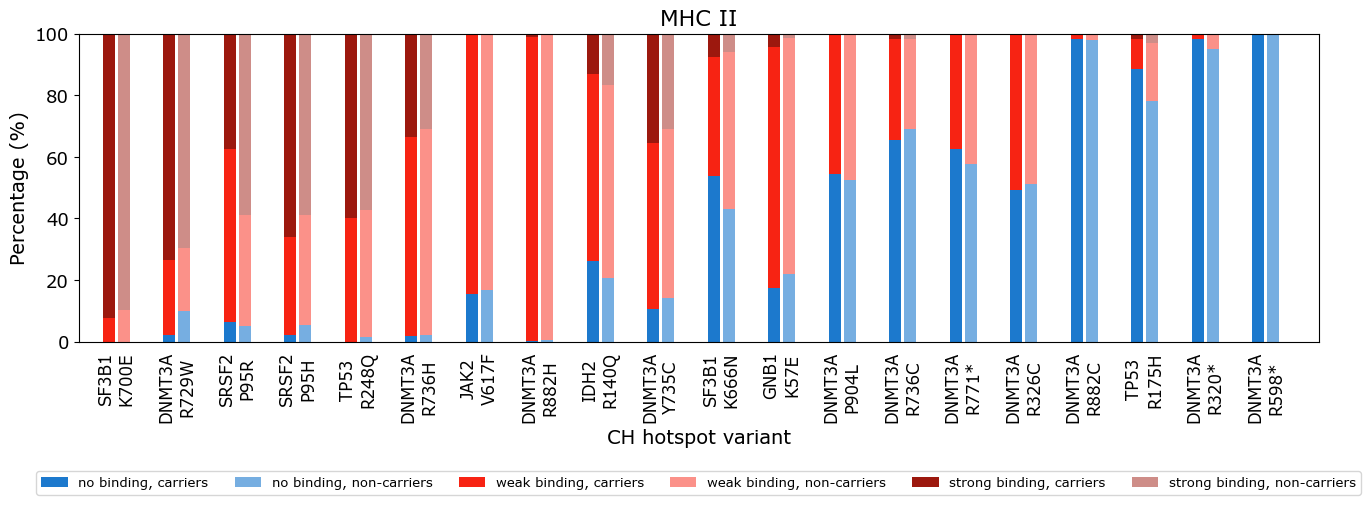

In [62]:

# Plotting
colors1 = ['#1c79cd', '#f72313', '#9c180e']
colors2 = ['#76aee1', '#fb9189', '#ce8d88']

plt.figure(figsize = (16, 4))

for i, var in enumerate(order_all):

    plt.bar(2*i, stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['no binding'], color=colors1[0], width=bar_width, label='no binding, carriers' if i == 0 else None)
    plt.bar(2*i+0.5, stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['no binding'], color=colors2[0], width=bar_width, label='no binding, non-carriers' if i == 0 else None)
    
    plt.bar(2*i, stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['weak binding'], color=colors1[1], width=bar_width, label='weak binding, carriers' if i == 0 else None, bottom=stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['no binding'])
    plt.bar(2*i+0.5, stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['weak binding'], color=colors2[1], width=bar_width, label='weak binding, non-carriers' if i == 0 else None, bottom=stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['no binding'])
    
    plt.bar(2*i, stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['strong binding'], color=colors1[2], width=bar_width, label='strong binding, carriers' if i == 0 else None, bottom=stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['no binding']+stacked_df_carriers[stacked_df_carriers['gene_var2']==var]['weak binding'])
    plt.bar(2*i+0.5, stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['strong binding'], color=colors2[2], width=bar_width, label='strong binding, non-carriers' if i == 0 else None, bottom=stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['no binding']+stacked_df_noncarriers[stacked_df_noncarriers['gene_var2']==var]['weak binding'])

plt.xlim(-1, 2*i+2)
order_all2 = [item for item in order_all for _ in range(2)]
tick_positions = [tick + 0.25 if i % 2 == 0 else tick for i, tick in enumerate(range(len(order_all) * 2))]
tick_labels = [f'{var}' if i % 2 == 0 else '' for i, var in enumerate(order_all2)]
plt.xticks(tick_positions, tick_labels, rotation=90, fontsize = 12)
plt.yticks(fontsize = 13)
plt.xlabel('CH hotspot variant', fontsize = 14)
plt.ylabel('Percentage (%)', fontsize = 14)
plt.title('MHC II', fontsize = 16)
plt.legend(bbox_to_anchor=(0.5, -0.4), loc='upper center', ncol = 6, fontsize = 9.5)
plt.tick_params(left = True, bottom = False) 
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 8/8b_UKBB_{param}_percentages_by_threshold_mhcii.pdf', bbox_inches='tight')

In [85]:
# look at VAF scores for cases where you have both binding and no binding 
ch_all_el_rank_log_labels = ch_hla_merge_sub_all[ch_hla_merge_sub_all['gene_var2'].isin(order)]

# let's add to everyone group based on score
conditions = [
    (ch_all_el_rank_log_labels['log_score'] < -1 * np.log10(5)),
    ((ch_all_el_rank_log_labels['log_score'] >= -1 * np.log10(5)) & (ch_all_el_rank_log_labels['log_score'] < -1 * np.log10(1))),
    (ch_all_el_rank_log_labels['log_score'] >= -1 * np.log10(1))]

values = ['no binding', 'weak binding', 'strong binding']
ch_all_el_rank_log_labels['binding'] = np.select(conditions, values)
ch_all_el_rank_log_labels['binding']= pd.Categorical(ch_all_el_rank_log_labels['binding'], categories=['no binding', 'weak binding', 'strong binding'], ordered=True)


### split by binding / non-binding to have more variants to look at 

In [86]:
# okay now binding / no binding
# look at VAF scores for cases where you have both binding and no binding 
ch_all_el_rank_log_labels = ch_all_el_rank_log_labels[ch_all_el_rank_log_labels['gene_var2'].isin(order)]

# let's add to everyone group based on score
conditions = [
    (ch_all_el_rank_log_labels['log_score'] < -1 * np.log10(5)),
    (ch_all_el_rank_log_labels['log_score'] >= -1 * np.log10(5))
]
values = ['no binding', 'binding']

ch_all_el_rank_log_labels['binding_any'] = np.select(conditions, values)
ch_all_el_rank_log_labels['binding_any']= pd.Categorical(ch_all_el_rank_log_labels['binding_any'], categories=['no binding', 'binding'], ordered=True)

In [89]:
# okay now repeat this but binding / no binding 

# define function to plot cumulative probability
def plot_cumulative_mhcii(data, x, y, hue, colors, xlabel, ylabel, var, score, name):

    var_name = var.split('_')[0:2]
    var_name = ' '.join(var_name)

    nr_cases = data.shape[0]

    plt.figure(figsize=(4,4)) 
    sns.lineplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = True)
    sns.scatterplot(x=x, y=y, data=data, hue=hue, palette=colors, legend = False, alpha = 0.3, linewidth=0)

    # specify title and axes labels 
    plt.title(f'{var_name} (n={nr_cases})', fontsize = 12)
    plt.xlabel(xlabel, fontsize = 10)
    plt.ylabel(ylabel, fontsize = 10)

    # convert both axes to log scale 
    plt.gca().set_xscale('log')
    plt.gca().set_yscale('log')

    # adjust legend 
    if var == 'DNMT3A_R326C':
        legend = plt.legend()
        legend.prop.set_size(10) 
        plt.legend(title = 'MHC II presentation', loc = 'lower left', fontsize = 10, title_fontsize = 11)
    else:
        plt.legend().remove()

    # specify ticks on the x axis 
    x_ticks = [1, 3, 10, 30]
    plt.xticks(x_ticks, x_ticks, fontsize = 9)

    y_ticks = [1, 0.3, 0.1, 0.03]
    plt.yticks(y_ticks, y_ticks, fontsize = 9)
    
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/folders_for_git/figure 8/UKBB_VAF_{hue}_{name}_{score}_{var}_threshold_mhcii.pdf', bbox_inches='tight')
    plt.close()

In [90]:
# okay now do the cumulative plots for this 

# plots scores for each group on the same plot 
# note: an alternative is to split by thresholds for binding  
# script to do this is included in the complete analysis, but I am not using this way due to issues described there 

# for extreme groups in each split 
dfs_list = ['ch_all_el_rank_log_labels']

for name in dfs_list:

    df = globals()[name]
    score = 'min_el_rank'
    
    df['VAF_percent'] = df['VAF'] * 100
    colors = colors1

    variants = df['gene_var'].unique()

    # plot for each variant separately 
    for var in variants: 

        data = df[df['gene_var'] == var]        
        data = data.sort_values(by='VAF')
        N = data.shape[0]
        
        # add number of people in each category 
        data['group_size'] = data.groupby('binding_any')['binding_any'].transform('count')
        data['index_vaf_group'] = data.groupby('binding_any')['VAF'].rank(ascending=False) # index by VAF
        data['fraction_index_presenter_group'] = data['index_vaf_group'] / data['group_size']
    
        plot_cumulative_mhcii(data, 'VAF_percent', 'fraction_index_presenter_group', 'binding_any', colors, 'VAF (%)', f'Cumulative probability', var, score, f'groups_thesholds_allon1')
